# ClonalOrigin model and simulation-based inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import torch
from sbi.utils.torchutils import BoxUniform
from sbi.inference import NPE_C, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import os

os.environ['R_HOME'] = r'C:\Program Files\R\R-4.5.1' # Set local R path
torch_device = "cpu"

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
c:\Users\u2008181\likelihood-free\sbi_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Test and run R function in python

Compare the running time for `ClonalOrigin_pair_seq.simulator` in my `simARG` package that simulates from the ClonalOrigin algorithm and provides summary statistics.

In [2]:
simARG = importr("simARG")

robjects.r('set.seed(100)')
tree = simARG.clonal_genealogy(int(15))
python_time = []
for i in range(1, 101):
    robjects.r(f'set.seed({i})')

    start_time = time.time()
    simARG.ClonalOrigin_pair_seq_simulator(
        tree,
        0.02,
        0.05,
        100000,
        300,
        100
    )
    end_time = time.time()
    python_time.append(end_time - start_time)

    print(f'Complete {i} iteration.')

Complete 1 iteration.
Complete 2 iteration.
Complete 3 iteration.
Complete 4 iteration.
Complete 5 iteration.
Complete 6 iteration.
Complete 7 iteration.
Complete 8 iteration.
Complete 9 iteration.
Complete 10 iteration.
Complete 11 iteration.
Complete 12 iteration.
Complete 13 iteration.
Complete 14 iteration.
Complete 15 iteration.
Complete 16 iteration.
Complete 17 iteration.
Complete 18 iteration.
Complete 19 iteration.
Complete 20 iteration.
Complete 21 iteration.
Complete 22 iteration.
Complete 23 iteration.
Complete 24 iteration.
Complete 25 iteration.
Complete 26 iteration.
Complete 27 iteration.
Complete 28 iteration.
Complete 29 iteration.
Complete 30 iteration.
Complete 31 iteration.
Complete 32 iteration.
Complete 33 iteration.
Complete 34 iteration.
Complete 35 iteration.
Complete 36 iteration.
Complete 37 iteration.
Complete 38 iteration.
Complete 39 iteration.
Complete 40 iteration.
Complete 41 iteration.
Complete 42 iteration.
Complete 43 iteration.
Complete 44 iteratio

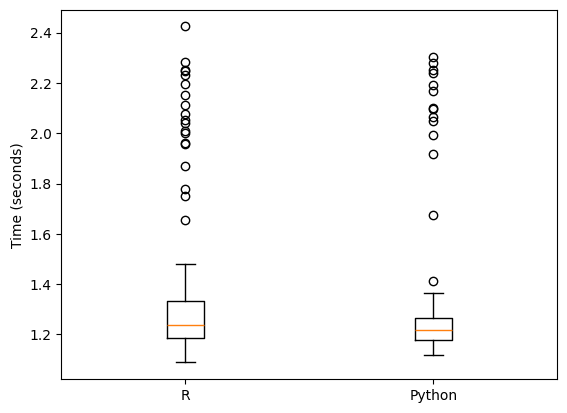

In [3]:
R_time = np.loadtxt("../data/ClonalOrigin_time.csv", skiprows=1)
plt.boxplot([R_time.tolist(), python_time], tick_labels=['R', 'Python'])
plt.ylabel('Time (seconds)')
plt.show()

## Observation data, simulator and prior

**Simulate observed data**

Set the true parameters as
* $\rho_s = 0.02$,
* $\delta = 300$,
* $\theta_s = 0.05$.

In [4]:
robjects.r('set.seed(100)')
x_o = simARG.ClonalOrigin_pair_seq_simulator(
    tree,
    0.02,
    0.05,
    100000,
    300,
    2000
)
x_o = torch.tensor(x_o, device=torch_device)
x_o = x_o.flatten()

x_o_numpy = x_o.cpu().numpy()

In [5]:
x_o

tensor([0.0096, 0.0056, 0.0025, 0.0020, 0.0080, 0.0075, 0.2025])

**Define prior distribution**

We set the prior to be uniform with range:
* $[0, 0.2]$ for $\rho_s$,
* $[1, 500]$ for $\delta$,
* $[0, 0.2]$ for $\theta_s$.

In [6]:
prior = BoxUniform(
    low=torch.tensor([0.0, 1.0, 0.0], device=torch_device),
    high=torch.tensor([0.2, 500.0, 0.2], device=torch_device), 
    device=torch_device
)

**Set the simulator with tensor output**

In [7]:
def simulator(theta):
    theta = theta.reshape(-1)
    summary_stats = simARG.ClonalOrigin_pair_seq_simulator(
        tree,
        theta[0].item(),
        theta[2].item(),
        100000,
        theta[1].item(),
        100
    )
    summary_stats = torch.tensor(summary_stats, device=torch_device)
    return summary_stats

In [8]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)

In [9]:
check_sbi_inputs(simulator, prior)

## NPE-C

In [10]:
simulation_budget = 5000
seed = 100
num_posterior_samples=1000
learning_rate = 0.0005

inference = NPE_C(prior=prior, density_estimator="nsf", device=torch_device)
torch.manual_seed(seed)
np.random.seed(seed)

**R objects via `rpy2` cannot be pickled for parallel processing!**

Progress bar: 1%|          | 58/5000 [07:20<8:11:54,  5.97s/it]

In [ ]:
theta, x = simulate_for_sbi(
    simulator=simulator, proposal=prior, num_simulations=simulation_budget, num_workers=1
)

In [ ]:
density_estimator = inference.append_simulations(theta, x).train(
    max_num_epochs=100, learning_rate=learning_rate
)
posterior = inference.build_posterior(density_estimator).set_default_x(x_o)

In [ ]:
theta_trained = posterior.sample((num_posterior_samples,), x=x_o)
theta_trained = theta_trained.reshape((num_posterior_samples, 2))